#### Problem statement

Build a prototype of online hate and abuse comment classifier which can used to classify hate and offensive comments so that it can be controlled and restricted from spreading hatred and cyberbullying.

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import string
import re
from collections import Counter
# packages from gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# packages from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

#packages from nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag

import warnings
warnings.filterwarnings('ignore')


from string import digits as d, punctuation as p
from nltk.tokenize import word_tokenize as wt


# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

# Model evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, auc

import re
import requests
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df_train.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
df_train.shape, df_test.shape

((159571, 8), (153164, 2))

In [6]:
df_train.isna().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

In [7]:
df_test.isna().sum()

id              0
comment_text    0
dtype: int64

In [8]:
df_train.nunique()

id                  159571
comment_text        159571
malignant                2
highly_malignant         2
rude                     2
threat                   2
abuse                    2
loathe                   2
dtype: int64

In [9]:
df_test.nunique()

id              153164
comment_text    153164
dtype: int64

In [10]:
# We can drop id which is unique
df_train.drop(['id'],axis=1, inplace=True)
df_test.drop(['id'],axis=1, inplace=True)

In [11]:
df_train.dtypes

comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object

In [12]:
# Creating a new feature label which represents comments not falling under other columns 
label_cols = [ 'malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe']
df_train['label'] = 1-df_train[label_cols].max(axis=1)
df_train.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


In [13]:
# 1: Non Malignant and 0: Malignant comments
df_train.label.value_counts()

1    143346
0     16225
Name: label, dtype: int64

In [14]:
# Adding new feature length to show the length of comments
df_train['length'] = df_train.comment_text.str.len()
df_train.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,264
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,112
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,233
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,622
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,67


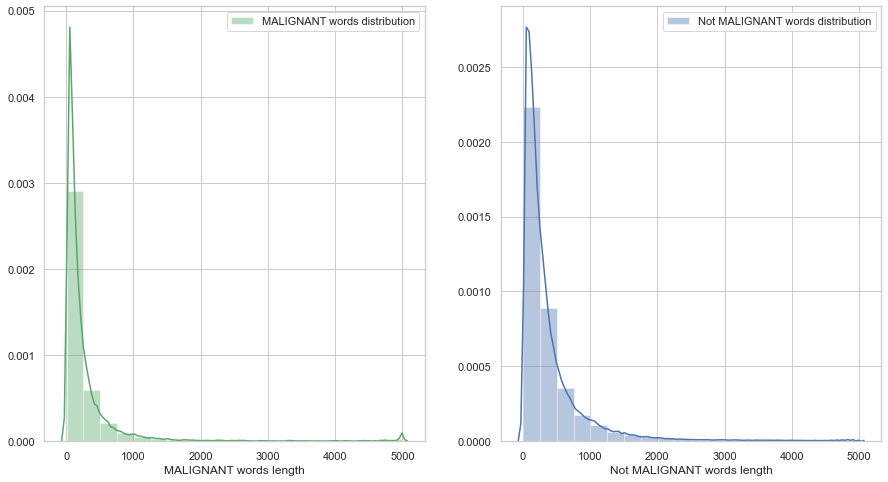

In [36]:
# Comments length distribution after cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_train[df_train['label']==0]['length'],bins=20,ax=ax[0],label='MALIGNANT words distribution',color='g')

ax[0].set_xlabel('MALIGNANT words length')
ax[0].legend()

sns.distplot(df_train[df_train['label']==1]['length'],bins=20,ax=ax[1],label='Not MALIGNANT words distribution')
ax[1].set_xlabel('Not MALIGNANT words length')
ax[1].legend()

plt.show()

In [15]:
# function to filter using POS tagging..
def get_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function for data cleaning...
def Processed_data(comments):
    # Replace email addresses with 'email'
    comments=re.sub(r'^.+@[^\.].*\.[a-z]{2,}$',' ', comments)
        
    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    comments=re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ',comments)
        
    # getting only words(i.e removing all the special characters)
    comments = re.sub(r'[^\w]', ' ', comments) 
        
    # getting only words(i.e removing all the" _ ")
    comments = re.sub(r'[\_]', ' ', comments) 
    
    # getting rid of unwanted characters(i.e remove all the single characters left)
    comments=re.sub(r'\s+[a-zA-Z]\s+', ' ', comments)
    
    # Removing extra whitespaces
    comments=re.sub(r'\s+', ' ', comments, flags=re.I)

    #converting all the letters of the review into lowercase
    comments = comments.lower()
    
    # splitting every words from the sentences
    comments = comments.split()

    # iterating through each words and checking if they are stopwords or not,
    comments=[word for word in comments if not word in set(STOPWORDS)]
    
    # remove empty tokens
    comments = [text for text in comments if len(text) > 0]
    
    # getting pos tag text
    pos_tags = pos_tag(comments)

    # considering words having length more than 3 only
    comments = [text for text in comments if len(text) > 3]        
   
    # performing lemmatization operation and passing the word in get_pos function to get filtered using POS ... 
    comments = [(WordNetLemmatizer().lemmatize(text[0], get_pos(text[1])))for text in pos_tags]

   # considering words having length more than 3 only
    comments = [text for text in comments if len(text) > 3]
    comments = ' '.join(comments)
    return comments

In [17]:
# cleaning the comments and storing them in a separate feature.
df_train["comment_text_cleaned"] = df_train["comment_text"].apply(lambda x: Processed_data(x))

In [18]:
df_train.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length,comment_text_cleaned
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,264,explanation edits username hardcore metallica ...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,112,match background colour seemingly stuck thanks...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,233,trying edit constantly removing relevant infor...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,622,real suggestion improvement wondered section s...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,67,hero chance remember page


In [19]:
# cleaning the comments and storing them in a separate feature fot test data
df_test["clean_comment_text"] = df_test["comment_text"].apply(lambda x: Processed_data(x))

In [20]:
df_test.head()

,comment_text,clean_comment_text
0,Yo bitch Ja Rule is more succesful then you'll...,bitch rule succesful whats hating mofuckas bit...
1,== From RfC == \n\n The title is fine as it is...,title fine
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",source zawe ashton lapland
3,":If you have a look back at the source, the in...",look source information updated correct form g...
4,I don't anonymously edit articles at all.,anonymously edit article


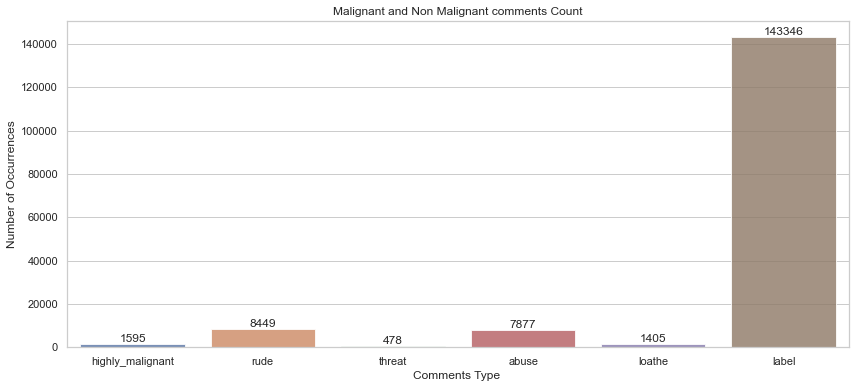

In [35]:
# Comment categories Counts
x = df_train.iloc[:,2:8].sum()
#plot
plt.figure(figsize=(14,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Malignant and Non Malignant comments Count")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Comments Type ', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [29]:
# for counting frequently occurence of Malignant and not Malignant words.
count1 = Counter(" ".join(df_train[df_train['label']==0]["comment_text_cleaned"]).split()).most_common(200)
count2 = Counter(" ".join(df_train[df_train['label']==1]["comment_text_cleaned"]).split()).most_common(200)
df=pd.DataFrame()
print("TOP 200 Words in Each Category (Word, Counts)")
df['Malignant Words']=count1
df['Not Malignant Words']=count2
df.head(10)

TOP 200 Words in Each Category (Word, Counts)


,Malignant Words,Not Malignant Words
0,"(fuck, 10080)","(article, 72346)"
1,"(suck, 4696)","(page, 54388)"
2,"(wikipedia, 3939)","(wikipedia, 44659)"
3,"(like, 3937)","(talk, 36421)"
4,"(shit, 3708)","(like, 24492)"
5,"(nigger, 3434)","(source, 21267)"
6,"(fucking, 3337)","(think, 19270)"
7,"(page, 2870)","(time, 17840)"
8,"(hate, 2713)","(know, 17687)"
9,"(faggot, 2496)","(edit, 17247)"


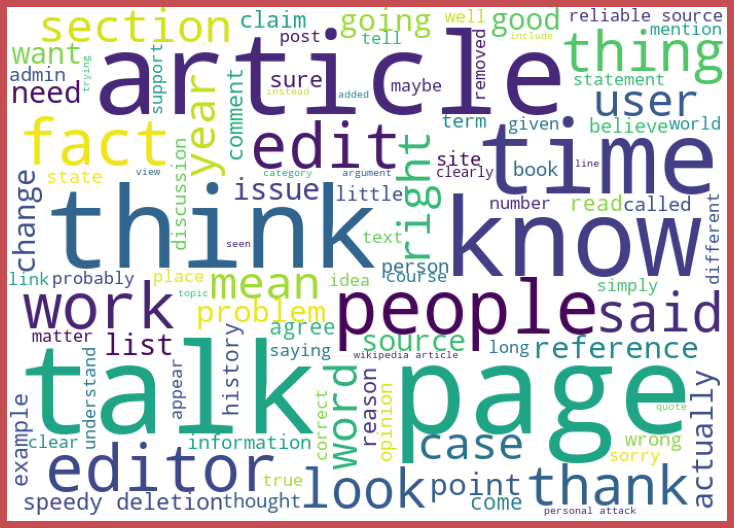

In [31]:
from wordcloud import WordCloud

not_mal = df_train["comment_text_cleaned"][df_train['label']==1]

not_mal_cloud = WordCloud(width=700,height=500,background_color='white',max_words=100).generate(' '.join(not_mal))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(not_mal_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

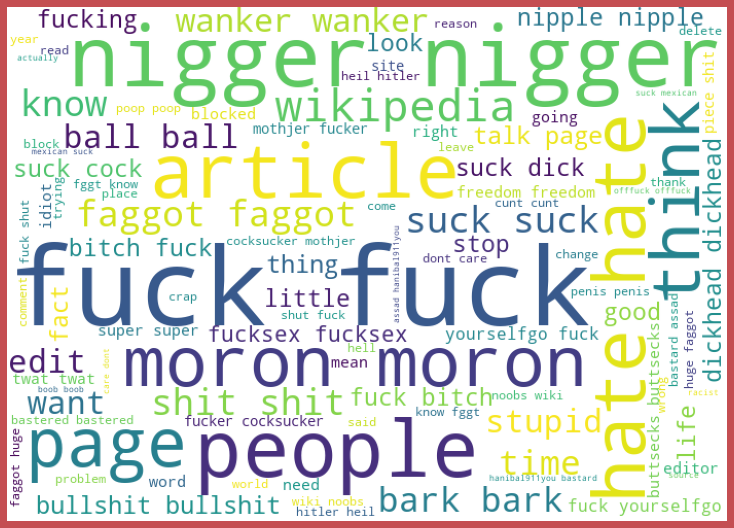

In [32]:
from wordcloud import WordCloud

mal = df_train["comment_text_cleaned"][df_train['label']==0]

mal_cloud = WordCloud(width=700,height=500,background_color='white',max_words=100).generate(' '.join(mal))

plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(mal_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vec = TfidfVectorizer(min_df=3, smooth_idf=False)

X = tf_vec.fit_transform(df_train['comment_text_cleaned'])
y = df_train['label']

In [40]:
X.shape, y.shape

((159571, 43194), (159571,))

In [43]:
# Split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=42)

In [44]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((127656, 43194), (31915, 43194), (127656,), (31915,))

In [45]:
# Put models in a dictionary
models = {
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier(),
          "xgb": XGBClassifier(),
          "PassiveAggressiveClassifier": PassiveAggressiveClassifier()
          }

# Create a function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [46]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)

model_scores

{'Logistic Regression': 0.9543161522794924,
 'Random Forest': 0.9552561491461695,
 'xgb': 0.9519034936550211,
 'PassiveAggressiveClassifier': 0.9441328528904903}

In [50]:
lr = LogisticRegression()
rf = RandomForestClassifier()
xgb = XGBClassifier()
pac = PassiveAggressiveClassifier()

In [51]:
models = []
models.append(('LogisticRegression', lr))
models.append(('RandomForestClassifier', rf))
models.append(('XGBClassifier', xgb))
models.append(('PasiveAggressiveClassifier', pac))

******************* LogisticRegression *******************

Accuracy_Score  =  95.43%
Cross_Val_Score =  95.42%
roc_auc_score   =  79.46%

 Classification_report 
               precision    recall  f1-score   support

           0       0.93      0.59      0.73      3244
           1       0.96      1.00      0.98     28671

    accuracy                           0.95     31915
   macro avg       0.94      0.79      0.85     31915
weighted avg       0.95      0.95      0.95     31915



Confusion Matrix 

 [[ 1927  1317]
 [  141 28530]]





******************* RandomForestClassifier *******************

Accuracy_Score  =  95.48%
Cross_Val_Score =  95.49%
roc_auc_score   =  81.29%

 Classification_report 
               precision    recall  f1-score   support

           0       0.89      0.63      0.74      3244
           1       0.96      0.99      0.98     28671

    accuracy                           0.95     31915
   macro avg       0.92      0.81      0.86     31915
weighted av

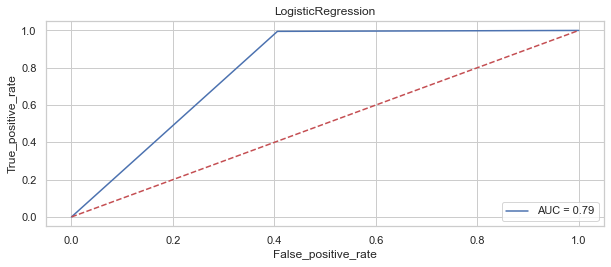

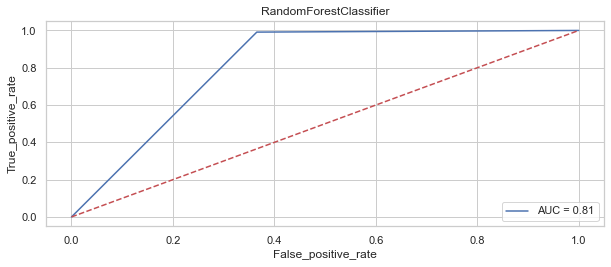

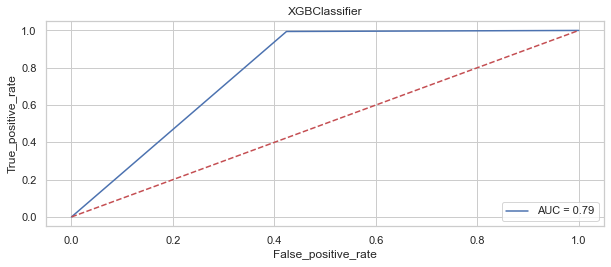

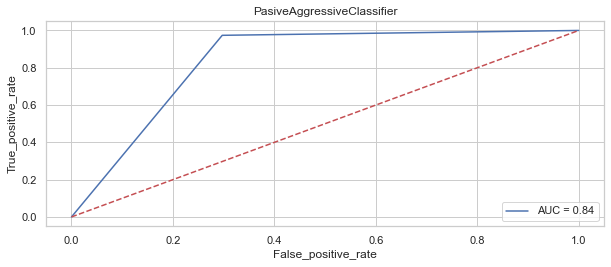

In [52]:
Model = []
score = []
cvs=[]
rocscore=[]
for name, model in models:
    print('*******************', name, '*******************\n') 
    Model.append(name)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    acc_score = accuracy_score(y_test, pred)
    print(f"Accuracy_Score  =  {acc_score*100:.2f}%")
    score.append(acc_score * 100)
    
    cross_val = cross_val_score(model, X, y, cv=10, scoring='accuracy').mean()
    print(f"Cross_Val_Score =  {cross_val*100:.2f}%")
    cvs.append(cross_val * 100)
     
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print(f"roc_auc_score   =  {roc_auc*100:.2f}%")
    rocscore.append(roc_auc * 100)
    
    print('\n Classification_report \n', classification_report(y_test, pred))
    print('\n')
    print('Confusion Matrix \n\n',confusion_matrix(y_test, pred))
    print('\n')  
    
    plt.figure(figsize=(10,40))
    plt.subplot(911)
    plt.title(name)
    plt.plot(false_positive_rate, true_positive_rate,label='AUC = %0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.ylabel('True_positive_rate')
    plt.xlabel('False_positive_rate')
    print('\n\n')

In [53]:
result = pd.DataFrame({'Model': Model, 'Accuracy_score': score ,'Cross_val_score':cvs,'Roc_auc_curve':rocscore})
result

,Model,Accuracy_score,Cross_val_score,Roc_auc_curve
0,LogisticRegression,95.431615,95.415206,79.455093
1,RandomForestClassifier,95.484882,95.488528,81.289068
2,XGBClassifier,95.190349,95.227828,78.528001
3,PasiveAggressiveClassifier,94.632618,94.634991,83.835602


Here we can see that PasiveAggressiveClassifier performed better than other models with ROC_AUC score of 83%. This can select as final model.

In [57]:
tf_vec = TfidfVectorizer(max_features=43194, smooth_idf=False)

X = tf_vec.fit_transform(df_test['clean_comment_text'])
X.shape

(153164, 43194)

In [58]:
# Predicting the test data
predtest = pac.predict(X)
pd.DataFrame(predtest).to_csv("malignant_predictions.csv")